In [1]:
import numpy as np
import h5py 
from sys import platform
from scipy import ndimage 
import torch
import torch.nn.functional as F
from torch import nn
from hip_unet import UNet
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load dataset from h5

# for data, i have total four cases data for train the deep convnets 
noOfCases = 4
X = np.zeros([noOfCases, 512, 512, 60],dtype='uint16')
y = np.zeros([noOfCases, 512, 512, 60,2],dtype='uint16') # last slice is for one-hot-encoding
filename = './data/HipSegmentation_2Sean.h5'
f1 = h5py.File(filename,'r')
for name, data in f1.items():
    if name == 'image':
        for i in range(noOfCases):
            tmp = data['%d'%(i+1)].value
            X[i] = np.rollaxis(tmp,0,3)
    elif name =='mask':
        for i in range(noOfCases):
            tmp = data['%d'%(i+1)].value
            y[i,...,1] = np.rollaxis(tmp,0,3)
            y[i,...,0] = 1-np.rollaxis(tmp,0,3)

In [3]:
X.shape

(4, 512, 512, 60)

In [4]:
y.shape

(4, 512, 512, 60, 2)

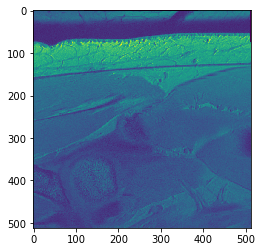

In [5]:
tmp2 = X[1][:,:,20]
plt.imshow(tmp2)

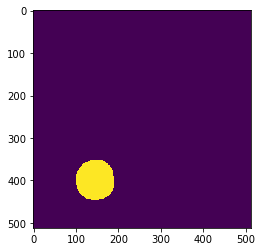

In [6]:
plt.imshow(y[1][:,:,20,1])

In [7]:
def compute_weights(y):
    flat_y = y.reshape([-1, 2])
    weight = flat_y[:,0].sum() / flat_y.sum()
    return (weight, 1-weight)

In [8]:
def zeroMeanUnitVariance(input_image):
  # zero mean unit variance
    augmented_image = np.zeros(input_image.shape,dtype='float32')
    for ci in range(input_image.shape[0]):
        mn = np.mean(input_image[ci, ...])
        sd = np.std(input_image[ci, ...])
        augmented_image[ci, ...] = (input_image[ci, ...] - mn) / np.amax([sd, 1e-5])
    return augmented_image
  

In [9]:
def get2DMultipleSlices(X_train,y_train,noOfCases):
    '''
    for the case of hop image, there are 60 slices of each image
    '''
    ct_train = 0
    train_X = np.zeros([noOfCases * 60, 512, 512, 3],dtype= 'float32')
    train_y = np.zeros([noOfCases * 60, 512, 512],dtype='uint16')
    for ii in range(X_train.shape[0]):
        tmp_X = X_train[ii]
        tmp_y = y_train[ii]
        for ti in range(tmp_X.shape[2]):
            if np.sum(tmp_y[...,ti,1])!=0:
                train_X[ct_train,:,:,:] = tmp_X[...,ti-1:ti+2] 
                train_y[ct_train,:,:] = tmp_y[...,ti,1] 
                ct_train += 1
               
    train_X = train_X[:ct_train]
    train_y = train_y[:ct_train]
    
    train_X = train_X.transpose(0,3,1,2)

    return train_X, train_y

In [10]:
# obtain 3 consecutive slices
X_new, y_new = get2DMultipleSlices(X, y, noOfCases)
X_new = zeroMeanUnitVariance(X_new)

In [51]:
X_new.shape

(114, 3, 512, 512)

In [52]:
y_new.shape

(114, 512, 512)

In [86]:
from torch.utils.data.dataset import Dataset
class HIP(Dataset):
    def __init__(self, X, y, subset="train", transform = None):
        
        # initialize variables
        self.subset = subset
        self.X = np.array(X, dtype=">f")
        self.y = np.array(y, dtype=">f")
        self.transform = transform


    def __getitem__(self, index):
    
        img = torch.from_numpy(self.X[index])
        target = torch.from_numpy(self.y[index])
        
        #crop target which match with final-input(324)
        target = target[94:-94,94:-94]

        # apply transforms to both
        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            
        return img, target

    def __len__(self):

        return self.X.shape[0]
     

In [87]:
dataset = HIP(X = X_new,
              y = y_new, 
              subset="train", 
              transform = None) 
# I do not need transform, coz my input is ndarary not PIL image 

In [88]:
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1,
                                           shuffle=True,
                                           pin_memory=False, # If True, the data loader will copy tensors into CUDA pinned memory before returning them.
                                           num_workers=0) # change to 1 if run in the server

In [89]:
val_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1,
                                           shuffle=True,
                                           pin_memory=False, # If True, the data loader will copy tensors into CUDA pinned memory before returning them.
                                           num_workers=0) # change to 1 if run in the server

In [90]:
im, lb = train_loader.dataset.__getitem__(1)

In [91]:
lb.size()

torch.Size([324, 324])

In [92]:
x = Variable(im)
x.size()

torch.Size([3, 512, 512])

In [93]:
class BCELoss2d(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(BCELoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        return self.bce_loss(probs_flat, targets_flat)
    

In [94]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        if use_cuda:
            data = Variable(data.cuda())
            target = Variable(target.cuda())
        else:
            data = Variable(data)
            target = Variable(target)
        
        #data =data.squeeze()
        #target =target.squeeze()
        #data = data.transpose(1,3).contiguous()
        #target = target.transpose(1,3).contiguous()


        print(data.size())
        print(target.size())
        
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.data[0]))

In [95]:
def evaluate():
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in val_loader:

        if use_cuda:
            data = Variable(data.cuda(), volatile=True)
            target = Variable(target.cuda())
        else:
            data = Variable(data, volatile=True)
            target = Variable(target)

        #data =data.squeeze()
        #target =target.squeeze()
        #data = data.transpose(1,3).contiguous()
        #target = target.transpose(1,3).contiguous()
        
        output = model(data)

        val_loss += criterion(output, target).data[0] # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    val_loss /= len(val_loader.dataset) # mean loss
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100 * correct / len(val_loader.dataset)))

In [96]:
use_cuda = torch.cuda.is_available()


In [97]:
import imp
import UNet
imp.reload(UNet)
from UNet import UNetOriginal


model = UNetOriginal([3,512,512])
criterion = BCELoss2d()

In [ ]:
optimizer = optim.SGD(model.parameters(),
                      weight_decay=1e-4,
                      lr=1e-4,
                      momentum=0.9,
                      nesterov=True)

for epoch in range(1, 3):
    train(epoch)
    evaluate()